In [1]:
from joblib import Parallel, delayed, cpu_count
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy import ndimage as ndi
from skimage.io import imread
from skimage.measure import label, find_contours
from skimage.morphology import square, binary_dilation
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from tqdm import tqdm
import tifffile as tf
from typing import Tuple

In [2]:
mask_folder_path = "/mnt/data/Imaging/202105-Deconwolf/data_210726/60x_mask/"
image_folder_path = "/mnt/data/Imaging/202105-Deconwolf/data_210726/60x_dw/"

Read previously generated mask, as input.

In [3]:
mask = imread(os.path.join(mask_folder_path, "a647_001.tif")).reshape((2048, 2048))
#plt.imshow(mask)

Apply Euclidean Distance Transform.

In [4]:
distance = ndi.distance_transform_edt(mask)
#plt.imshow(distance)

Apply watershed after identifying local maxima. Some parameters should be fine-tuned:
    
- `threshold_abs`: Minimum intensity of peaks. In this case, the minimum distance from the background (or nuclear contour).
- `min_distance`: The minimal allowed distance separating peaks
- `footprint`: If provided, `footprint == 1` represents the local region within which to search for peaks at every point in `image`.
    
More details on the function are available [here](https://scikit-image.org/docs/stable/api/skimage.feature.html#peak-local-max).

In [5]:
coords = peak_local_max(distance,
                        threshold_abs=22,
                        min_distance=20,
                        footprint=square(30))
peaks_mask = np.zeros(distance.shape, dtype=bool)
peaks_mask[tuple(coords.T)] = True
peaks_markers, _ = ndi.label(peaks_mask)
labels0 = label(mask)
for i in tqdm(range(1, labels0.max()+1)):
    if 500 > np.sum(labels0 == i):
        labels0[labels0 == i] = 0
labels = watershed(-distance, peaks_markers, mask=mask)+labels0*100
#plt.imshow(peaks_mask)

100%|██████████| 190/190 [00:01<00:00, 108.62it/s]


In [6]:
# Re-filter size after watersheding
for i in tqdm(sorted(set(np.unique(labels)))):
    if 500 > np.sum(labels == i):
        labels[labels == i] = 0
# Relabel to avoid missing labels
for i, v in tqdm(tqdm(enumerate(sorted(set(np.unique(labels)))))):
    labels[labels == v] = i

100%|██████████| 201/201 [00:01<00:00, 125.29it/s]
0it [00:00, ?it/s]
26it [00:00, 255.71it/s]
53it [00:00, 257.44it/s]
79it [00:00, 256.08it/s]
106it [00:00, 259.36it/s][A
132it [00:00, 257.53it/s]
155it [00:00, 248.44it/s]
182it [00:00, 254.57it/s]
182it [00:00, 254.96it/s]


In [7]:
#plt.imshow(labels, cmap="hsv")

Plot contours, as a visual sanity-check.

100%|██████████| 181/181 [00:11<00:00, 15.09it/s]


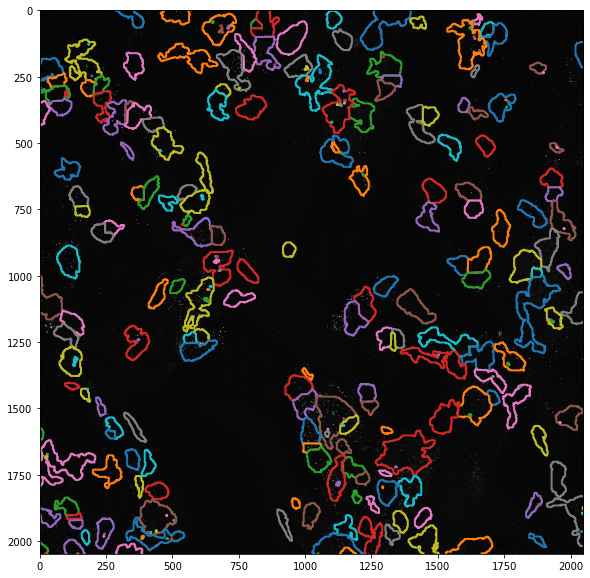

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(imread(os.path.join(image_folder_path, "a647_001.tif")).sum(0)*-1,
          cmap="binary", interpolation="none")
for i in tqdm(range(1, labels.max()+1)):
    for contour in find_contours(labels == i, .5):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

# Process

1. Separate all masks
2. Dilate each mask
3. EDT on each dilate mask
4. Sum all dilated masks
5. Pixels with value > 1
    - If already in a mask, skip. Otherwise,
    - Check the EDT of all masks where the pixel is present and assign the label of the one with the lowest EDT

#### Split all labeled masks to separate slices over Z

In [9]:
single_masks = np.array([i == labels for i in range(0, labels.max()+1)])
single_masks[0, :, :] = np.zeros(single_masks.shape[1:])

#### Filling single masks

In [10]:
single_filled_masks = np.array(Parallel(n_jobs=min(20, cpu_count()), verbose=10)(
    delayed(ndi.binary_fill_holes)(single_masks[i, :, :])
    for i in range(single_masks.shape[0])))

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done  21 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=20)]: Done  58 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done  73 tasks      | elapsed:    1.7s
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:    1.9s
[Parallel(n_jobs=20)]: Done 105 tasks      | elapsed:    2.3s
[Parallel(n_jobs=20)]: Done 122 tasks      | elapsed:    2.6s
[Parallel(n_jobs=20)]: Done 141 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 162 out of 182 | elapsed:    3.2s remaining:    0.4s
[Parallel(n_jobs=20)]: Done 182 out of 182 | elapsed:    3.5s finished


In [11]:
filled_labels = np.zeros(labels.shape)
for i in range(single_filled_masks.shape[0]):
    filled_labels += single_filled_masks[i, :, :] * i
filled_labels = filled_labels.astype("int64")

#### Dilate each slice (i.e., labeled mask) separately

In [12]:
dilation_radius = 30
single_dilated_masks = np.array(Parallel(n_jobs=min(20, cpu_count()), verbose=10)(
    delayed(binary_dilation)(single_filled_masks[i, :, :], square(30))
    for i in range(single_filled_masks.shape[0])))

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    4.9s
[Parallel(n_jobs=20)]: Done  21 tasks      | elapsed:    8.8s
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    9.3s
[Parallel(n_jobs=20)]: Done  45 tasks      | elapsed:   13.1s
[Parallel(n_jobs=20)]: Done  58 tasks      | elapsed:   13.6s
[Parallel(n_jobs=20)]: Done  73 tasks      | elapsed:   17.7s
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:   21.5s
[Parallel(n_jobs=20)]: Done 105 tasks      | elapsed:   25.7s
[Parallel(n_jobs=20)]: Done 122 tasks      | elapsed:   29.6s
[Parallel(n_jobs=20)]: Done 141 tasks      | elapsed:   33.7s
[Parallel(n_jobs=20)]: Done 162 out of 182 | elapsed:   38.0s remaining:    4.7s
[Parallel(n_jobs=20)]: Done 182 out of 182 | elapsed:   41.5s finished


#### Identify overlapping mask pixels (i.e., uncertain pixels)

In [13]:
dilation_sum = single_dilated_masks.sum(0)
uncertain_pixels = np.logical_and(dilation_sum > 1, np.logical_not(filled_labels != 0))
uncertain_coords = np.array(np.where(uncertain_pixels))
#uncertain_coords.shape

#### Identify non-overlapping portion of dilated masks

In [14]:
certain_pixels = np.logical_and(dilation_sum == 1, np.logical_not(filled_labels != 0))
certain_pixel_values = np.array([single_dilated_masks[i, :, :]*i
                                 for i in tqdm(range(single_dilated_masks.shape[0]))])
for i in tqdm(range(certain_pixel_values.shape[0])):
    certain_pixel_values[i, np.logical_not(certain_pixels)] = 0

100%|██████████| 182/182 [00:08<00:00, 20.86it/s]


#### Apply EDT to dilated masks, separately, to use the distance value for label assignment

In [15]:
def edt_from_center_of_mass(img2d: np.ndarray) -> np.ndarray:
    assert 2 == len(img2d.shape), img2d.shape
    if 0 == img2d.sum():
        return img2d
    cx, cy = ndi.center_of_mass(img2d)
    center_mask = np.ones(img2d.shape[-2:])
    center_mask[int(np.floor(cx)), int(np.floor(cy))] = 0
    center_edt = ndi.distance_transform_edt(center_mask)
    center_edt[np.logical_not(img2d)] = 0
    return center_edt

def edt_bg_from_particle(img2d: np.ndarray) -> np.ndarray:
    assert 2 == len(img2d.shape), img2d.shape
    if 0 == img2d.sum():
        return img2d
    return ndi.distance_transform_edt(img2d == 0)

single_edt = np.array(Parallel(n_jobs=min(20, cpu_count()), verbose=10)(
    delayed(edt_bg_from_particle)(single_filled_masks[i, :, :])
    for i in range(single_filled_masks.shape[0])))

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Batch computation too fast (0.0587s.) Setting batch_size=2.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=20)]: Done  21 tasks      | elapsed:    2.1s
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Batch computation too slow (3.6175s.) Setting batch_size=1.
[Parallel(n_jobs=20)]: Done  50 tasks      | elapsed:    4.6s
[Parallel(n_jobs=20)]: Done  76 tasks      | elapsed:    7.3s
[Parallel(n_jobs=20)]: Done 106 tasks      | elapsed:   10.5s
[Parallel(n_jobs=20)]: Done 128 tasks      | elapsed:   12.7s
[Parallel(n_jobs=20)]: Done 162 out of 182 | elapsed:   15.6s remaining:    1.9s
[Parallel(n_jobs=20)]: Done 182 out of 182 | elapsed:   17.3s finished


In [16]:
#plt.figure(figsize=(10,10))
#plt.imshow(edt_bg_from_particle(single_filled_masks[50,:,:]))

# Assign uncertain pixels based on EDT

In [17]:
dilated_labels = filled_labels.copy()
# Fix uncertain pixels
for i in tqdm(range(uncertain_coords.shape[1])):
    icoords = uncertain_coords.transpose()[i, :]
    overlapping_labels = np.where(single_dilated_masks[:, icoords[0], icoords[1]])[0]
    selected_label = overlapping_labels[np.argmin(
        single_edt[overlapping_labels, icoords[0], icoords[1]])]
    dilated_labels[icoords[0], icoords[1]] = selected_label
dilated_labels += certain_pixel_values.sum(0)

100%|██████████| 108013/108013 [00:01<00:00, 102643.06it/s]


In [18]:
#fig, ax = plt.subplots(figsize=(30,15), nrows=1, ncols=2)
#ax[0].imshow(dilated_labels)
#ax[1].imshow(filled_labels)

100%|██████████| 181/181 [00:23<00:00,  7.60it/s]


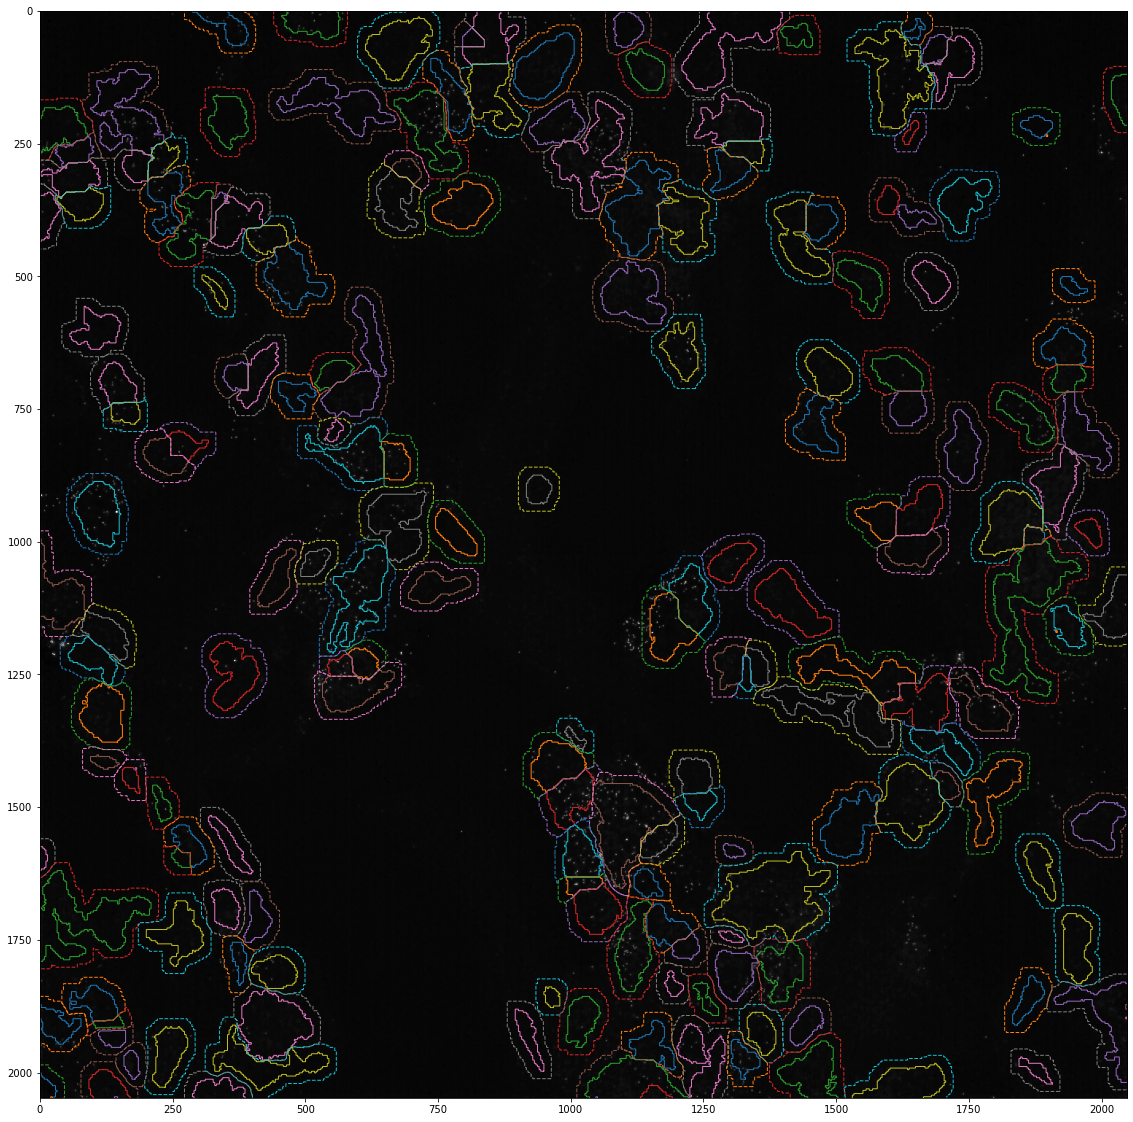

In [19]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(imread(os.path.join(image_folder_path, "a647_001.tif")).sum(0)*-1,
          cmap="binary", interpolation="none")
for i in tqdm(range(1, filled_labels.max()+1)):
    for contour in find_contours(filled_labels == i, .5):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1)
    for contour in find_contours(dilated_labels == i, .5):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, linestyle='--')